In [57]:
from collections import defaultdict

import pandas as pd
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AffinityPropagation
from sklearn.metrics import silhouette_score

In [24]:
config_path = "../config.yaml"
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

PLAYLIST_COUNT_THRESHOLD = 100

df = pd.read_csv("../data/raw_data/user_playlists.csv")
# Preprocess
significant_playlists = df.groupby("playlist_name").size().where(lambda size: size > 100).dropna().index
df = df[df["playlist_name"].isin(significant_playlists)].copy()

In [11]:
features = config["data"]["raw_features"]
features

['acousticness',
 'danceability',
 'energy',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'speechiness',
 'tempo',
 'valence']

In [12]:
df[features].dtypes

acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
key                   int64
liveness            float64
loudness            float64
mode                  int64
speechiness         float64
tempo               float64
valence             float64
dtype: object

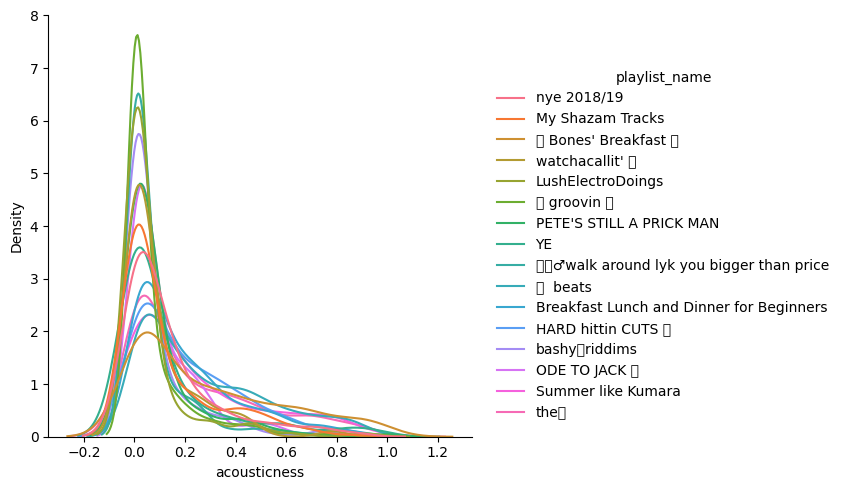

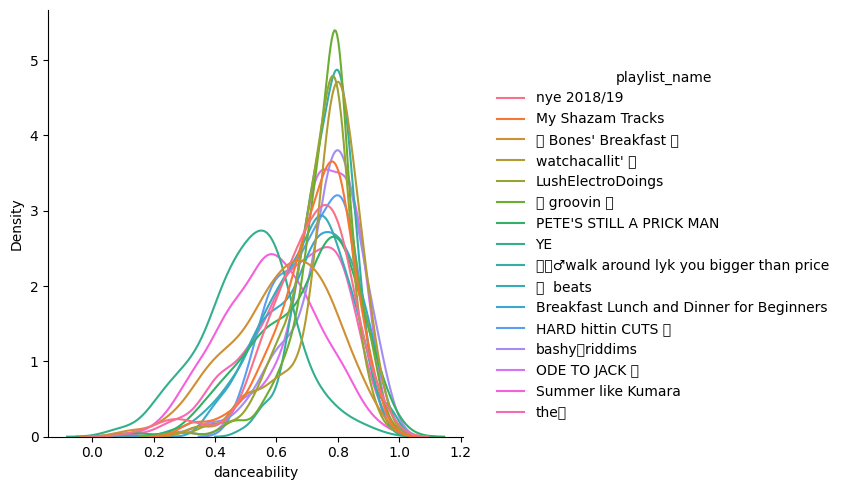

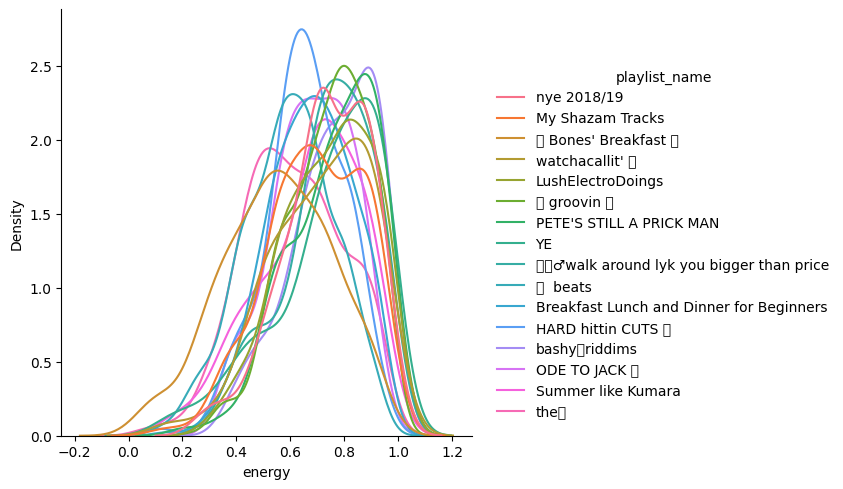

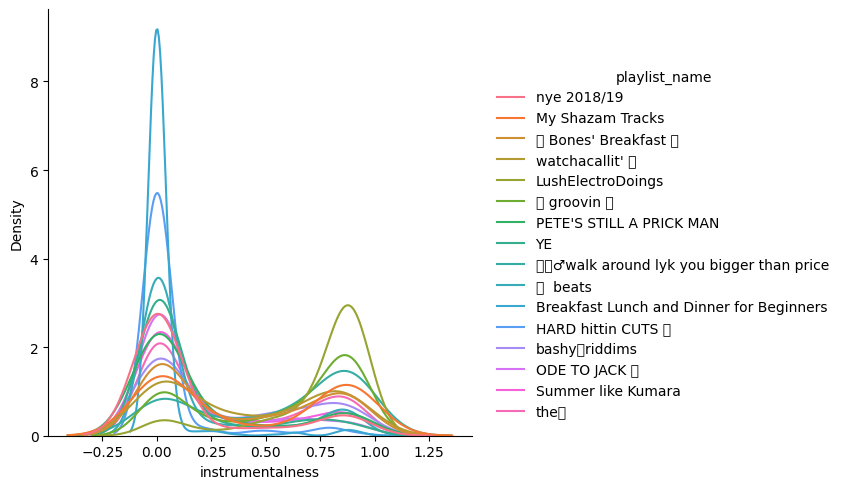

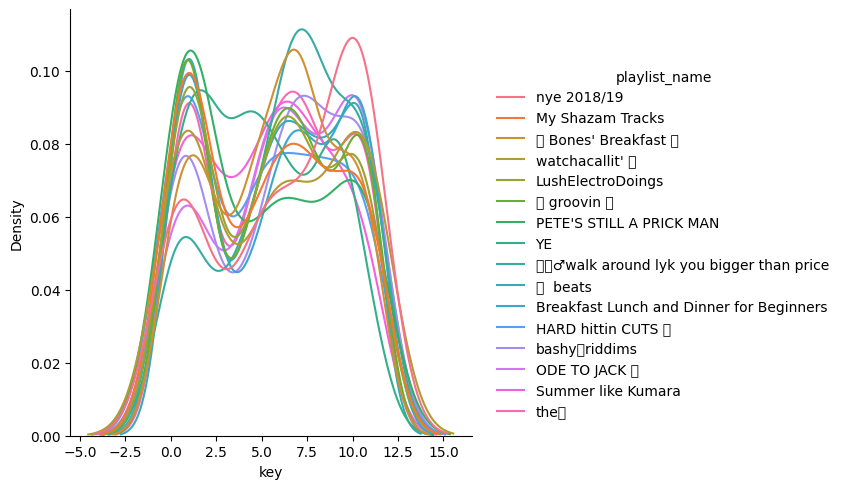

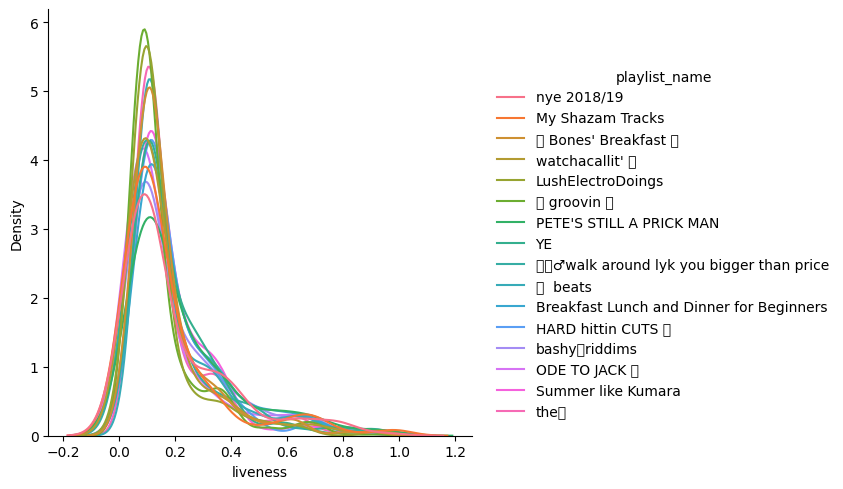

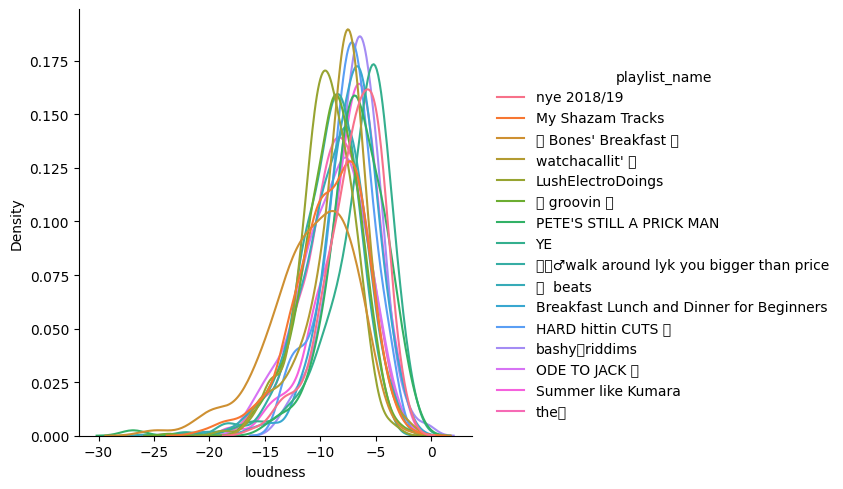

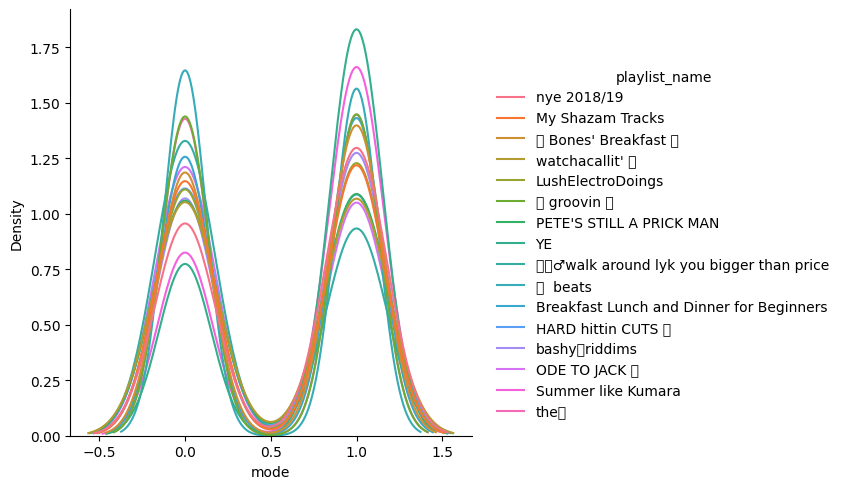

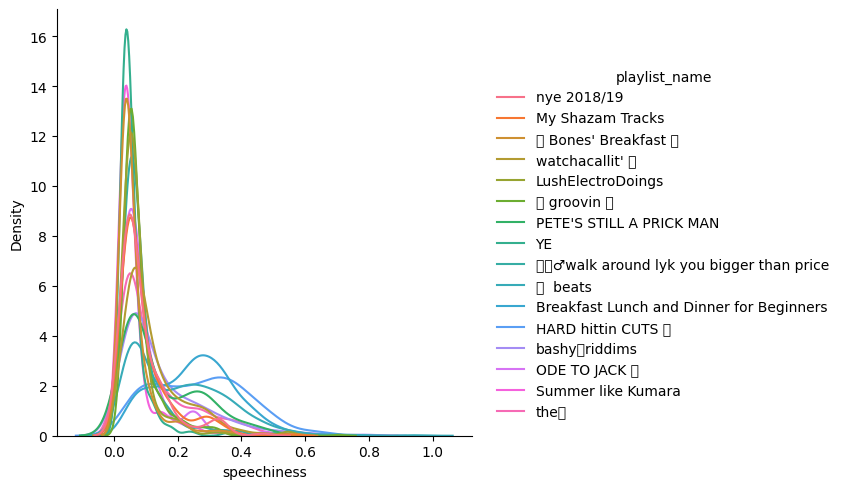

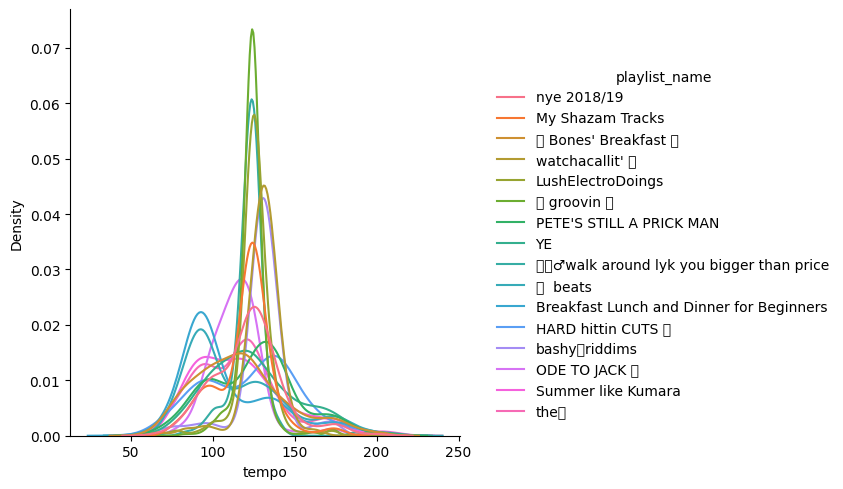

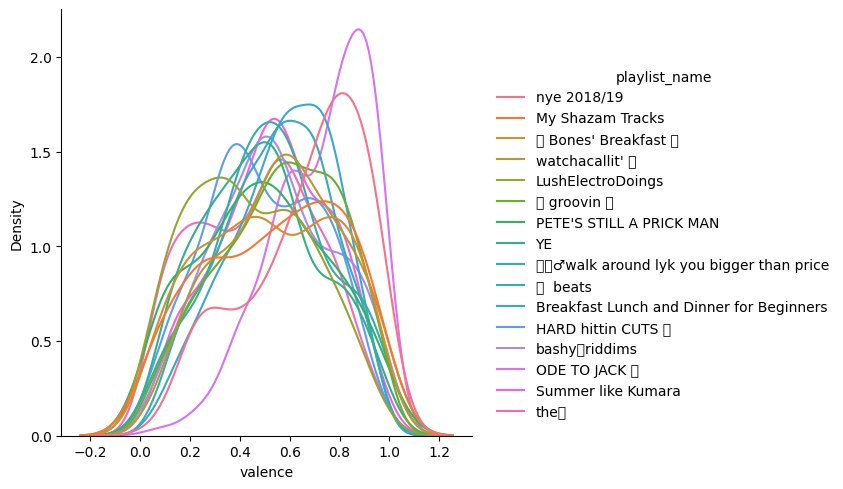

In [31]:
for feature in features:
    sns.displot(data=df, x=feature, hue="playlist_name", kind="kde", common_norm=False)
    plt.show()

In [32]:
df.shape

(5164, 18)

### Check an individual playlist

go for bones breakfast and see what the diff types of clusters it comes to are
Start with k-means and vary by k.  get the elbow curve and then see what the clusters look like in terms of actual songs

In [35]:
bones = "Bones'"

In [36]:
df_b = df[df["playlist_name"].str.contains(bones)].copy()

In [38]:
df_b.groupby("playlist_name").size()

playlist_name
🍳 Bones' Breakfast 🥞    353
dtype: int64

In [39]:
X = df_b[features].copy()

In [58]:
# think more about scores: https://scikit-learn.org/1.5/api/sklearn.metrics.html#module-sklearn.metrics.cluster
results = defaultdict(list)
index = []
for n in range(2, 15):
    kmeans = KMeans(n_clusters=n)
    preds = kmeans.fit_predict(X)
    results["inertia"].append(kmeans.inertia_)
    results["sil_score"].append(silhouette_score(X, preds))
    index.append(n)
df_results = pd.DataFrame(results, index=index)

In [59]:
df_results

,inertia,sil_score
2,110458.630204,0.543288
3,51717.537687,0.510329
4,35198.485401,0.471590
5,23680.484974,0.455391
6,20491.785481,0.396943
7,17872.880674,0.369130
8,15634.849478,0.378647
9,13980.151071,0.342729
10,12946.537137,0.314813
11,12220.293923,0.301694


<Axes: ylabel='inertia'>

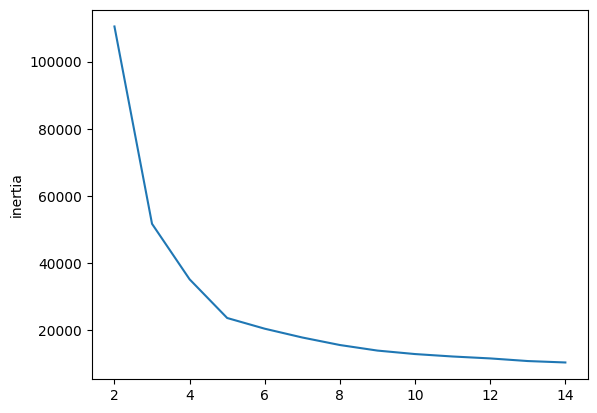

In [60]:
sns.lineplot(df_results["inertia"])

5 seems decent

In [62]:
kmeans = KMeans(n_clusters=5)
preds = kmeans.fit_predict(X)
df_b5 = df_b.assign(cluster=preds)

In [66]:
analysis_features = ["artist", "name", "album", "cluster"]
df_b5[analysis_features]

,artist,name,album,cluster
408,Orange Juice,Rip It Up,Rip It Up,3
409,J Dilla,Sounds Like Love (J Dilla instrumental),Yancey Boys (Instrumentals),4
410,Maxwell Owin,Come With the Ragga,Come With the Ragga,1
411,Yazmin Lacey,Own Your Own,Morning Matters,2
412,MMYYKK,Soulmate (Heartstrings),Love In Synthesis,0
...,...,...,...,...
756,Cousin,Pistol Shrimp,Hudson,4
757,Space Ghost,Peace Waves,Aquarium Nightclub,2
758,Jean Tonique,too bad,sunny side up,0
759,Tornado Wallace,Healing Feeling,Lonely Planet,0


In [65]:
df_b5["cluster"].value_counts()

cluster
0    108
3     94
2     66
1     54
4     31
Name: count, dtype: int64

In [69]:
df_b5[df_b5["cluster"] == 4][analysis_features].sort_values("artist")

,artist,name,album,cluster
517,ARTHUR,Woof Woof,Woof Woof,4
706,Air,Modular Mix,Modulor Mix,4
676,André 3000,Dreams Once Buried Beneath The Dungeon Floor S...,New Blue Sun,4
590,Bran Van 3000,Drinking in L.A.,Glee,4
565,Contour,Lies,Weight,4
756,Cousin,Pistol Shrimp,Hudson,4
540,Crass,Banned from the Roxy,The Feeding of the 5000 (Remastered),4
409,J Dilla,Sounds Like Love (J Dilla instrumental),Yancey Boys (Instrumentals),4
741,Jespfur,Sinkin,Mind Map,4
622,Khruangbin,August Twelve,The Universe Smiles Upon You,4


In [73]:
df_b5[df_b5["cluster"] == 0][analysis_features].sort_values("artist").head(40)

,artist,name,album,cluster
732,Alex G,In My Arms,House of Sugar,0
695,Alex Kassian,Leave Your Life - Dance Mix,Leave Your Life,0
548,Arche,My Only,My Only,0
550,Beat Happening,Our Secret,Beat Happening,0
748,BeerbellyJake,Punk,Fantazia,0
558,Blanketman,Taking You With Me,Taking You With Me,0
699,Brad stank,O.T.D.,Daddy Blue / O.T.D.,0
591,Bush Tetras,Snakes Crawl,Boom in the Night,0
470,Café Türk,Ali Baba from Istanbul,Café Türk,0
665,Cousin,2 - Icy Dub,Numina,0


SHITE!